- plot corr of pred and corr of res in the brain
- try training with both feature spaces
- try predict with prediction from one brain region to another

In [170]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ranksums
import matplotlib.pyplot as plt
from util.util import pearson_corr

sns.set(style="whitegrid")

In [4]:
from util.model_config import ecc_roi_names, visual_roi_names, place_roi_names

In [38]:
nested_roi = {"ecc_rois":ecc_roi_names, "visual_rois": visual_roi_names, "place_rois": place_roi_names}

In [5]:
%matplotlib inline

In [6]:
dfpath = "../output/dataframes/correlations_subj1_no_sig_mask.csv"

In [54]:
df = pd.read_csv(dfpath)

In [55]:
print(df.columns)

Index(['Unnamed: 0', 'ecc_rois', 'place_rois', 'visual_rois',
       'vanishing_point', 'edge2d', 'edge3d', 'keypoint2d', 'keypoint3d',
       'segment25d', 'segmentsemantic', 'room_layout', 'class_places',
       'class_1000'],
      dtype='object')


In [56]:
tasks = df.columns[4:]
print(tasks)

Index(['vanishing_point', 'edge2d', 'edge3d', 'keypoint2d', 'keypoint3d',
       'segment25d', 'segmentsemantic', 'room_layout', 'class_places',
       'class_1000'],
      dtype='object')


In [65]:
def make_ranksum_plot(df, roi_label, task_to_compare, other_tasks):
    plt.figure()
    fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20,20), sharey=True)
    for i, task in enumerate(other_tasks):
        dist_diffs = list()
        roi_list= list(nested_roi[roi_label].values())
        for roi in roi_list:
            rs = ranksums(df[task_to_compare][df[roi_label] == roi], df[task][df[roi_label] == roi])
            dist_diffs.append(rs[0])
        sns.lineplot(x=np.arange(0,len(roi_list)), y=dist_diffs, ax=axes.flat[i])
        axes.flat[i].set_xlabel(" ".join(roi_label.split("_")))
        axes.flat[i].set_ylabel("Ranksum")
        axes.flat[i].set_xticks(range(len(roi_list)))
        axes.flat[i].set_xticklabels(roi_list)
        axes.flat[i].set_title(str(task))

<Figure size 432x288 with 0 Axes>

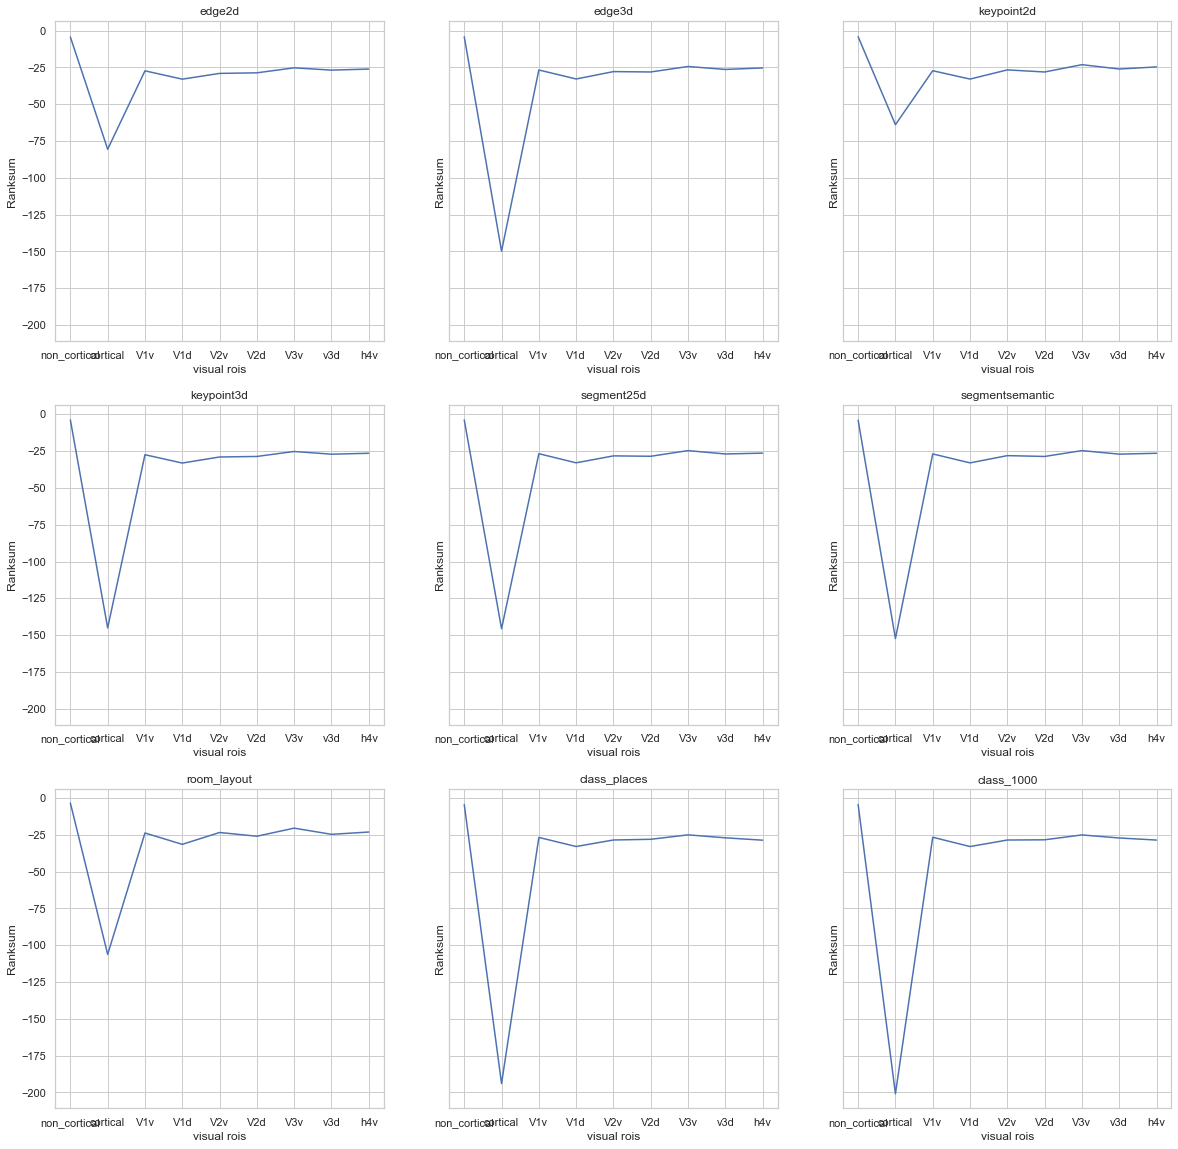

In [66]:
make_ranksum_plot(df, 'visual_rois', tasks[0], tasks[1:])

<Figure size 432x288 with 0 Axes>

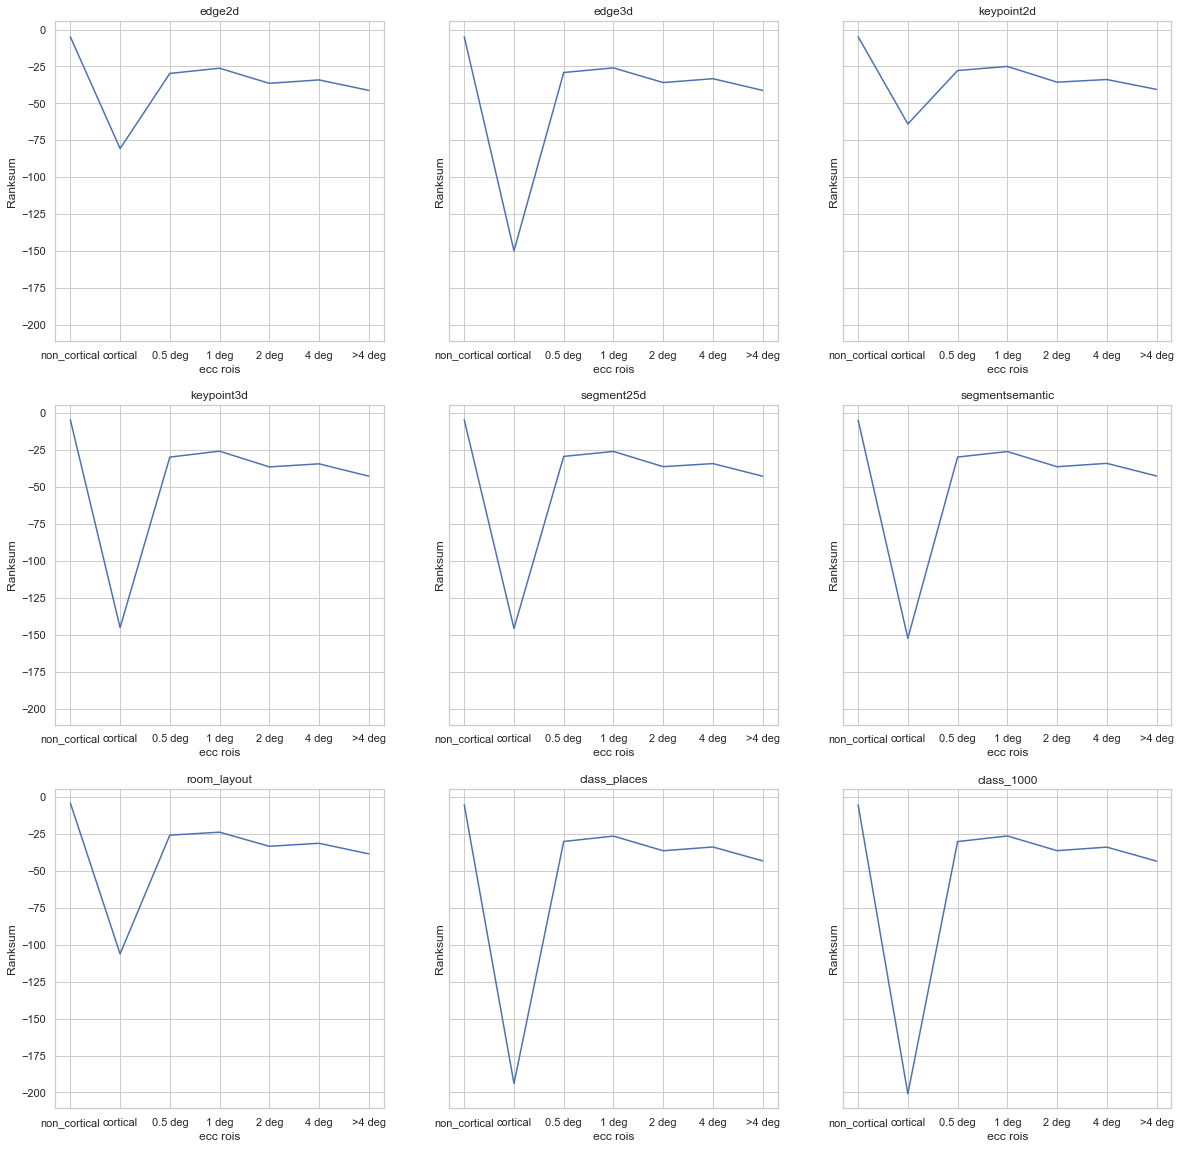

In [67]:
make_ranksum_plot(df, 'ecc_rois', tasks[0], tasks[1:])

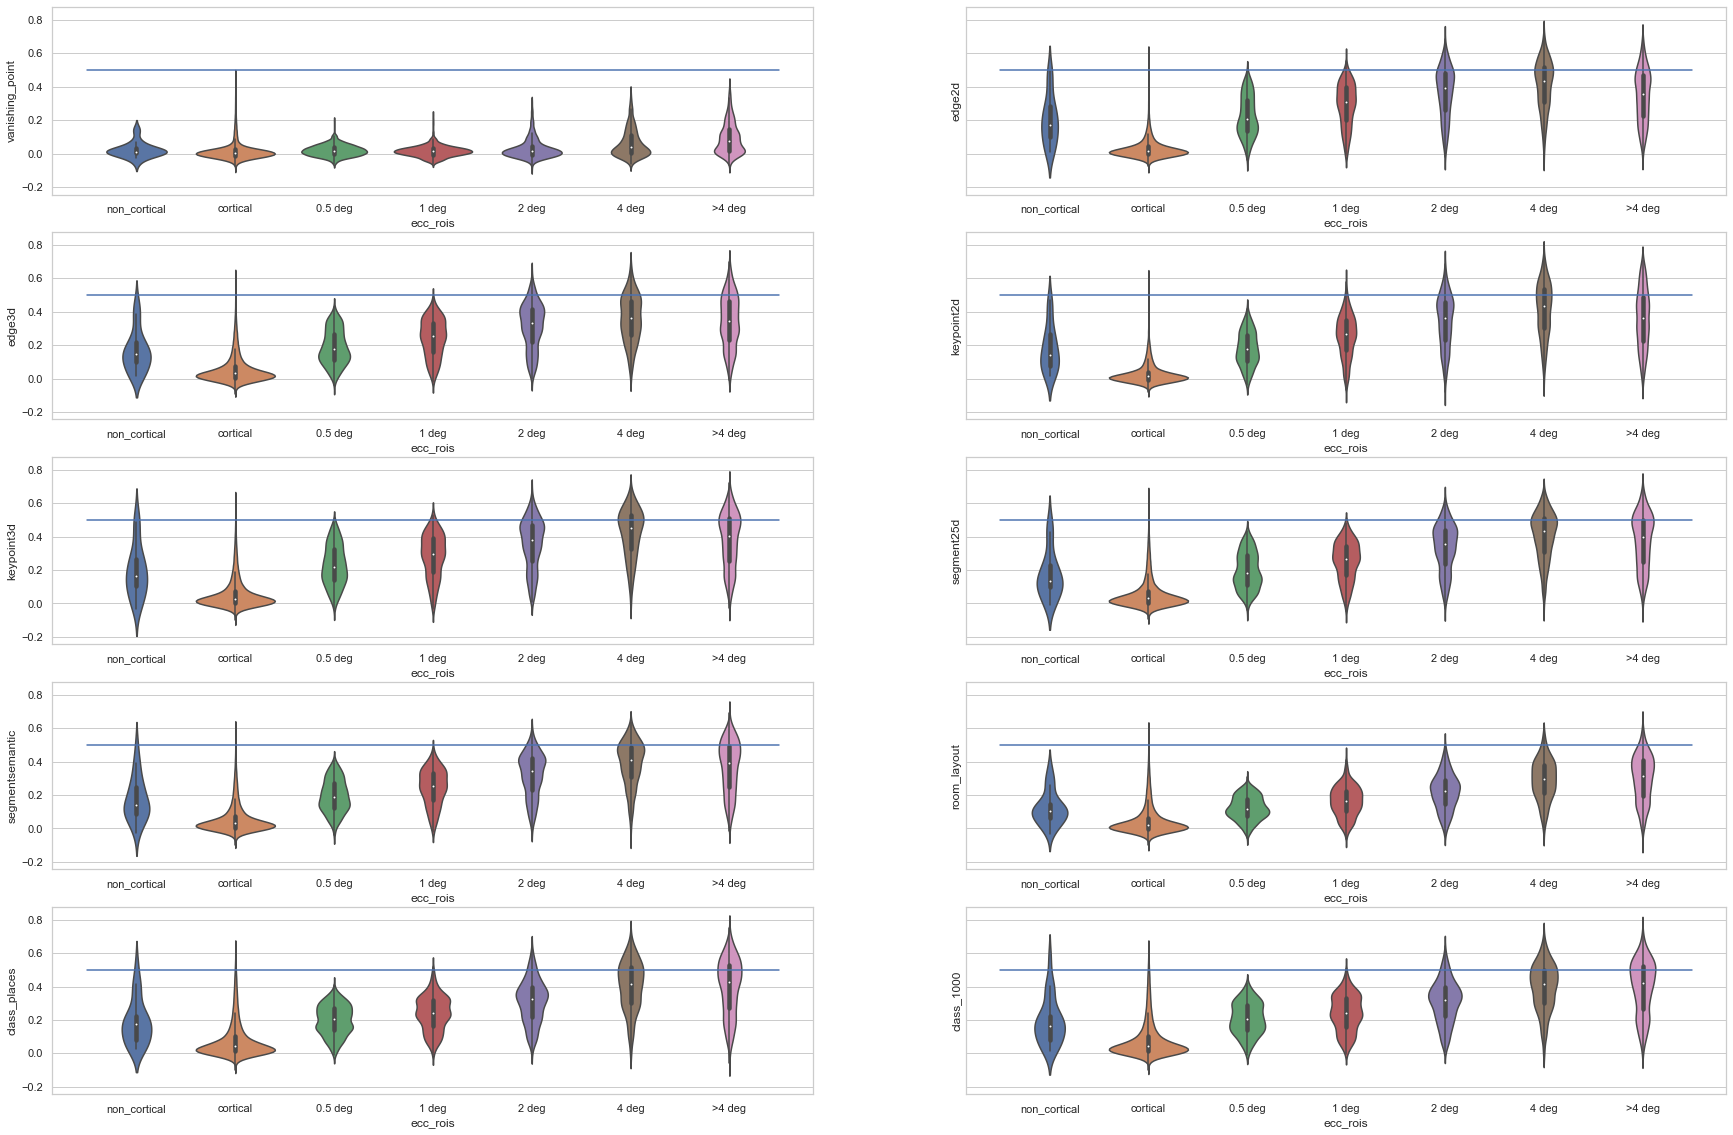

In [85]:
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(30,20),sharey=True)
for i, ax in enumerate(axes.flat):
    sns.violinplot(x=df["ecc_rois"], order=list(ecc_roi_names.values()), y=df[tasks[i]], ax=ax)
    sns.lineplot(x=(-0.5,6.5),  y=0.5, ax=ax)

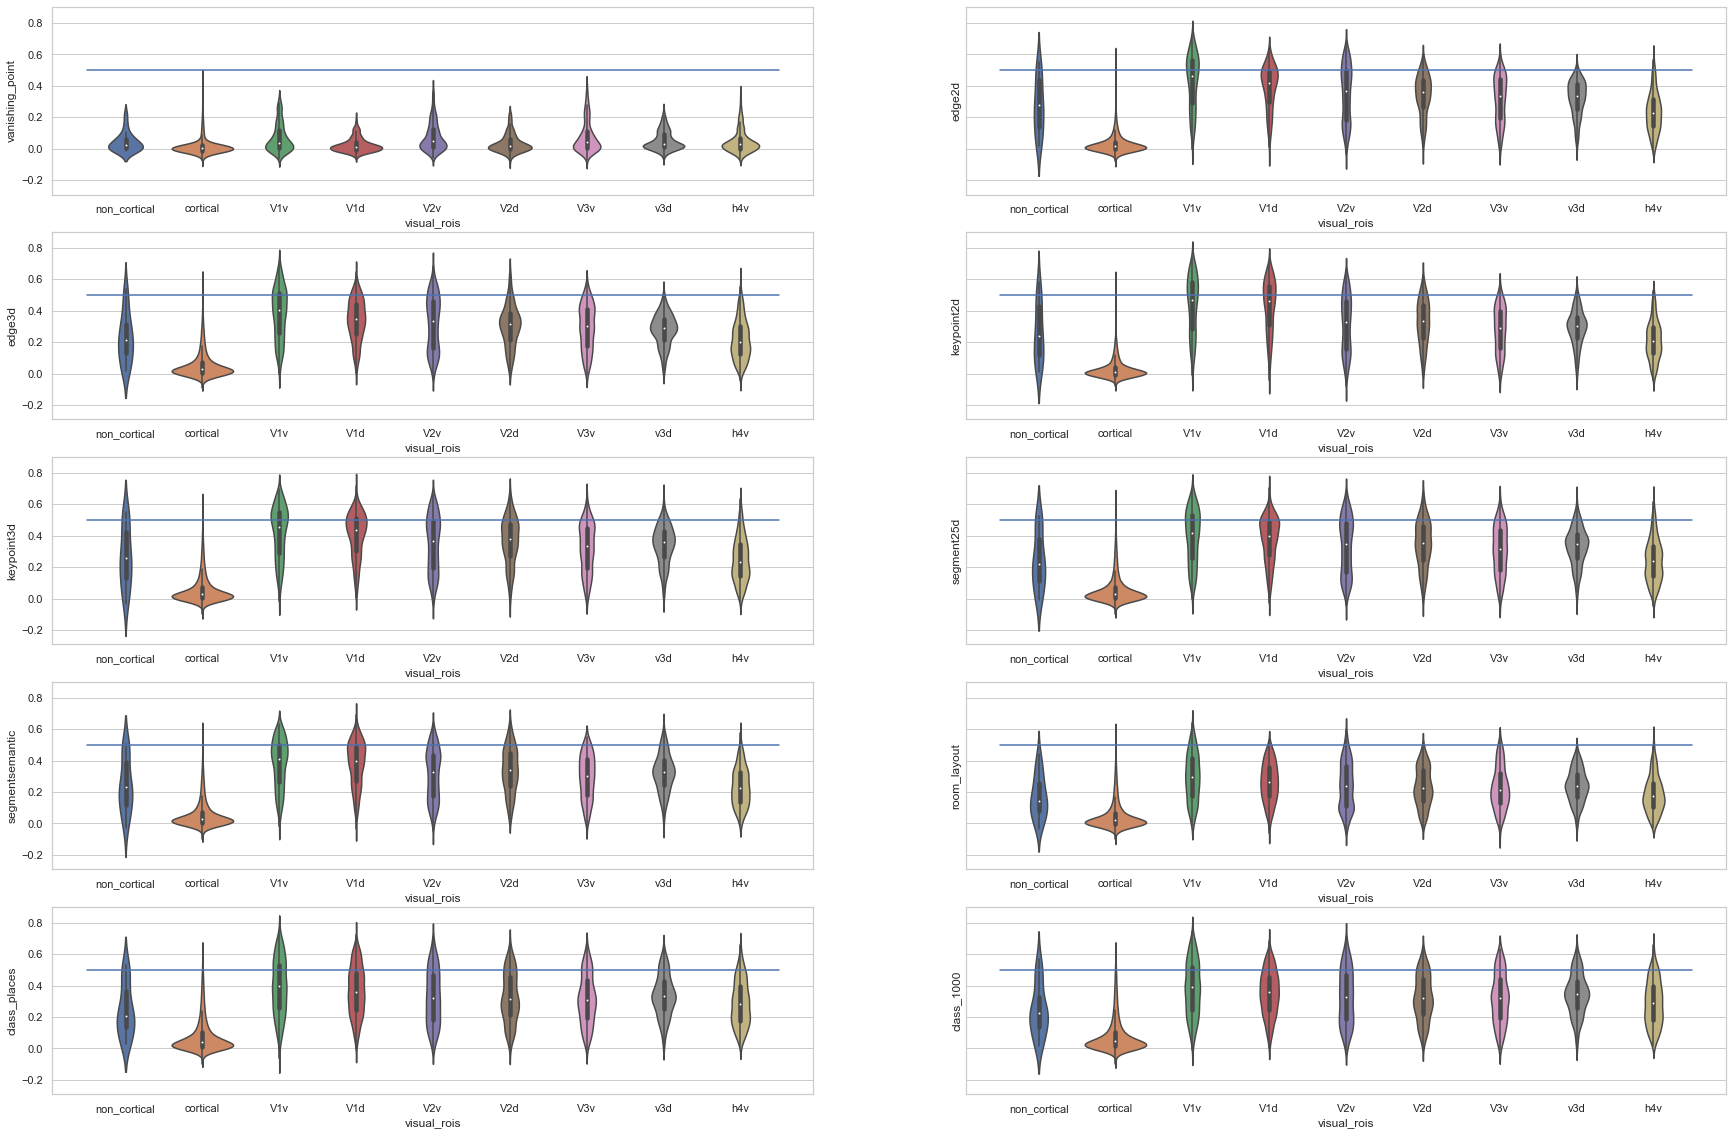

In [84]:
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(30,20), sharey=True)
for i, ax in enumerate(axes.flat):
    sns.violinplot(x=df["visual_rois"], y=df[tasks[i]], order=list(visual_roi_names.values()), ax=ax)
    sns.lineplot(x=(-0.5,8.5),  y=0.5, ax=ax)

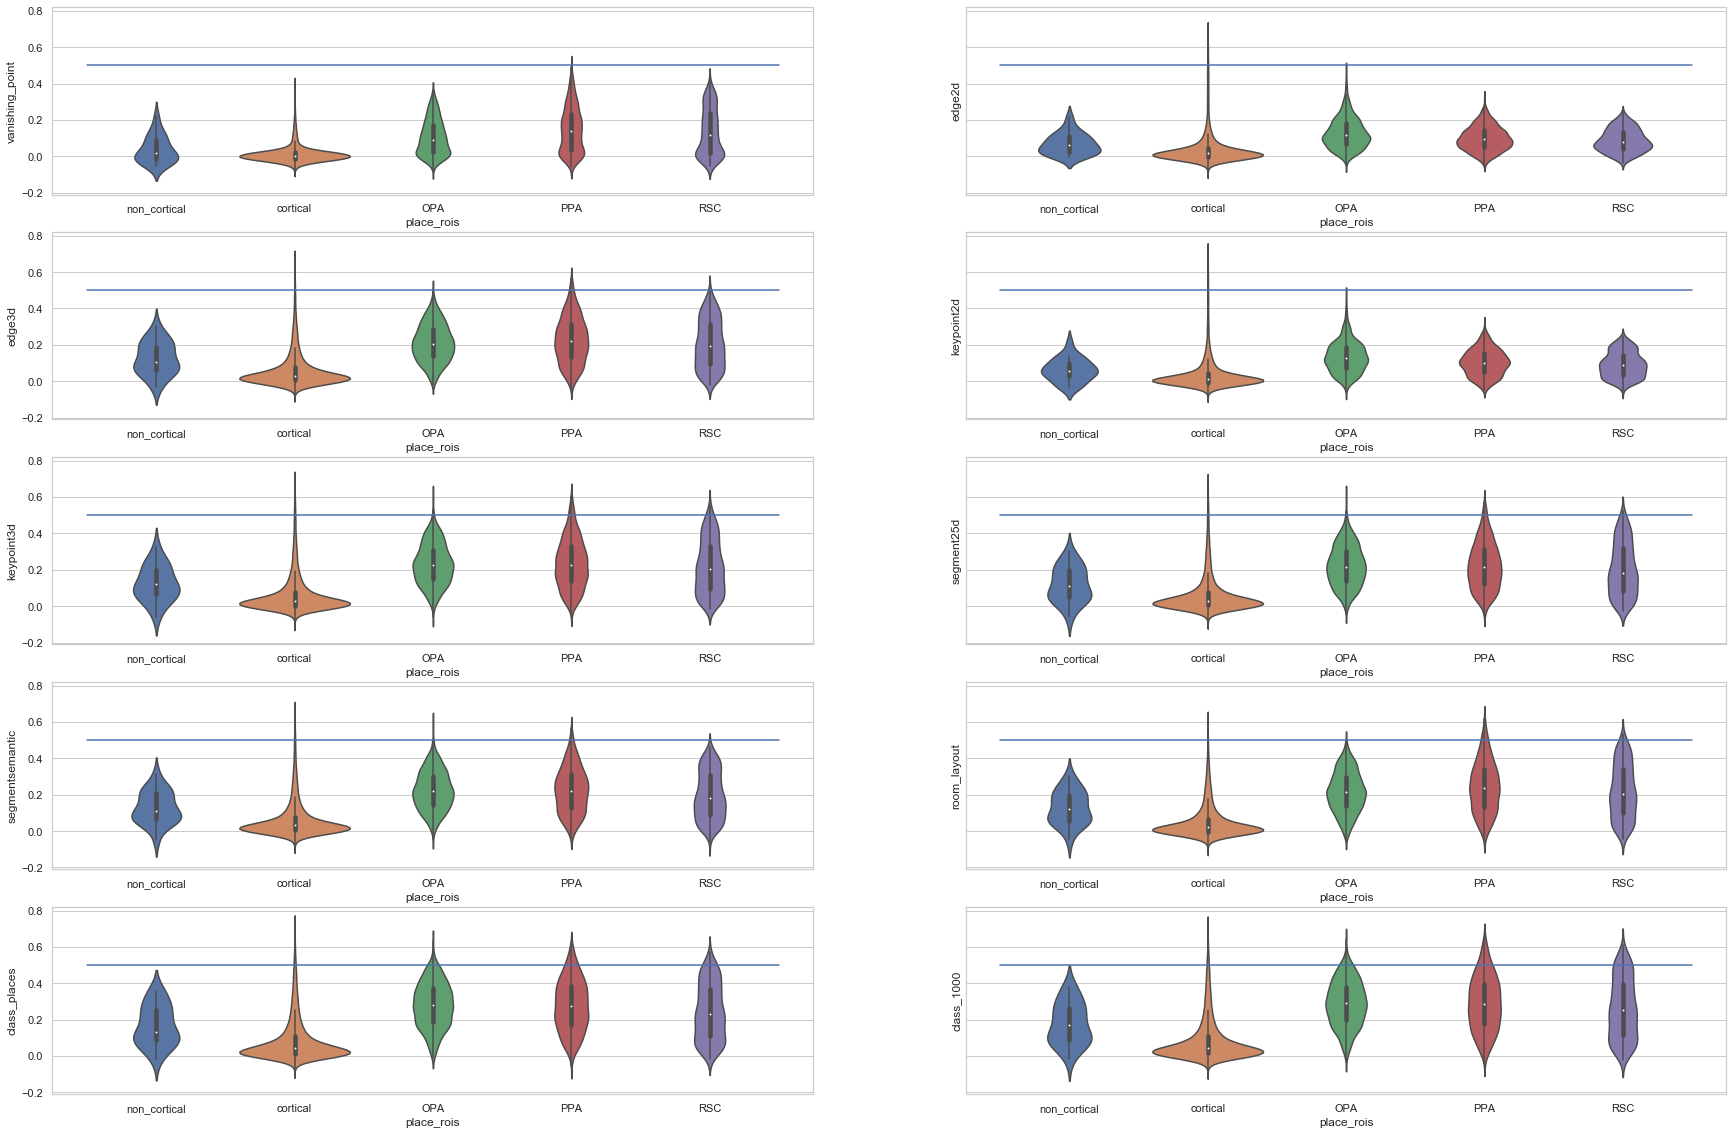

In [91]:
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(30,20), sharey=True)
for i, ax in enumerate(axes.flat):
    sns.violinplot(x=df["place_rois"], y=df[tasks[i]], order=place_roi_names.values(), ax=ax)
    sns.lineplot(x=(-0.5,4.5),  y=0.5, ax=ax)

# Prediction difference in class 1000 and class places

In [167]:
def plot_diff(task1, task2):
    pred1 = pickle.load(open("../output/encoding_results/subj1/pred_taskrepr_%s_whole_brain.p" % task1, "rb"))[0]
    pred2 = pickle.load(open("../output/encoding_results/subj1/pred_taskrepr_%s_whole_brain.p" % task2, "rb"))[0]

    print("num of voxel with correlation score over 0.5 for task %s: %d" % (task1, np.sum(df[task1]>0.5)))
    print("num of voxel with correlation score over 0.5 for task %s: %d" % (task2, np.sum(df[task2]>0.5)))

    overlap_index = ((df[task1]>0.5).astype(int)*(df[task2]>0.5).astype(int)).astype(bool).values
    print("num of overlap voxels: " + str(np.sum(overlap_index)))

    
    corr_dist = pearson_corr(pred1[:,overlap_index].T, pred2[:,overlap_index].T)

    plt.hist(corr_dist)

    ranksum_dist = ranksums(pred1[:,overlap_index], pred2[:,overlap_index])
    print(ranksum_dist)

    avg = (df[task1][overlap_index] + df[task2][overlap_index])/2

    plt.figure(figsize=(20,5))
    sns.lineplot(x=avg, y=corr_dist)
    plt.title("Correlation of prediction make by two models")
    plt.xlabel("Averaged model performances")

    plt.figure(figsize=(20,5))
    sns.scatterplot(x=avg, y=df[task1][overlap_index], alpha=0.3, label=task1)
    sns.scatterplot(x=avg, y=df[task2][overlap_index], alpha=0.3, label=task2)
    plt.xlabel("Averaged model performances")
    plt.ylabel("Model performance")

num of voxel with correlation score over 0.5 for task class_1000: 1475
num of voxel with correlation score over 0.5 for task class_places: 1354
num of overlap voxels: 1222
RanksumsResult(statistic=91274.51883235753, pvalue=0.0)


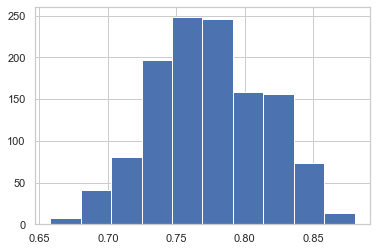

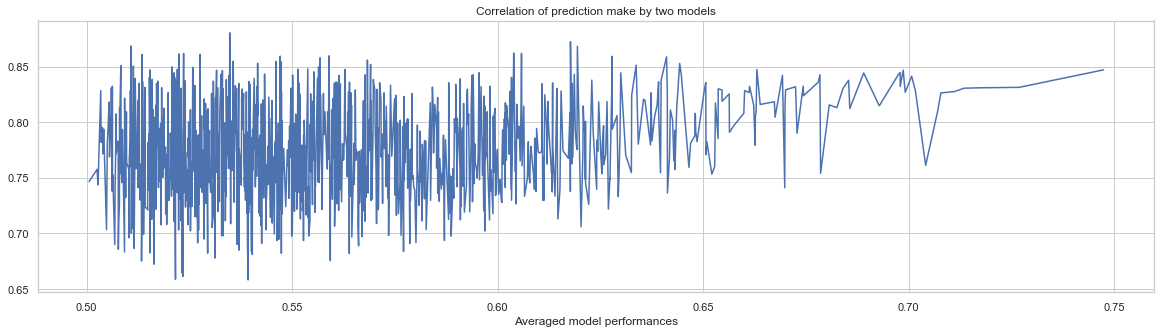

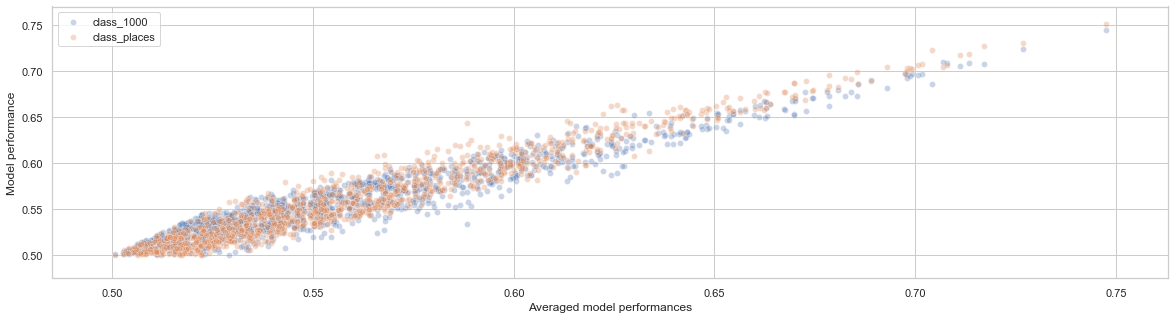

In [168]:
plot_diff('class_1000', 'class_places')

num of voxel with correlation score over 0.5 for task room_layout: 182
num of voxel with correlation score over 0.5 for task class_places: 1354
num of overlap voxels: 181
RanksumsResult(statistic=13807.321578850946, pvalue=0.0)


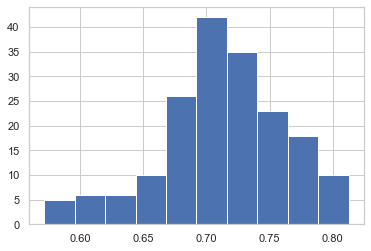

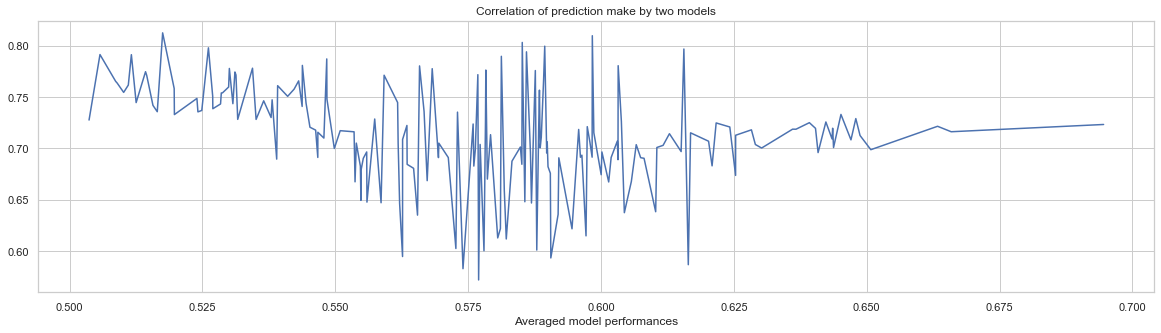

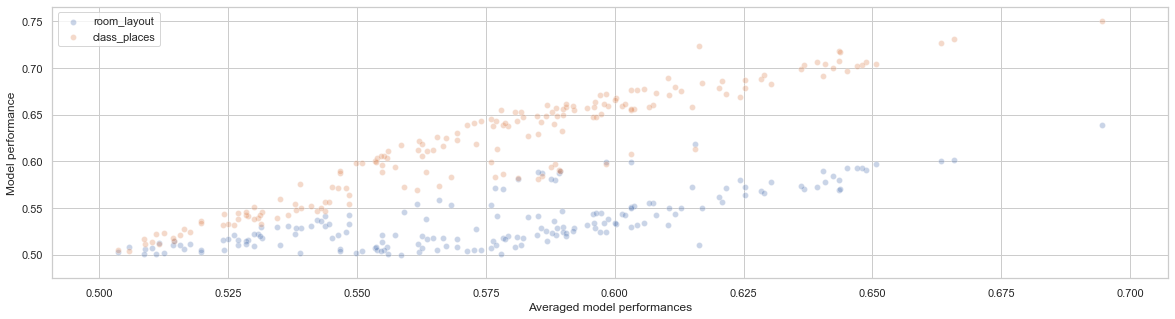

In [169]:
plot_diff('room_layout', 'class_places')

# Residual